In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime,timedelta
from collections import Counter
from tqdm import tqdm
import glob

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from data_augment import *

### Now Doing the training
#Focusing on years post 2008

In [2]:
data=pd.read_csv("Generated Data/atp_data_augmented2.csv", encoding = "ISO-8859-1")
num_df = data.iloc[:,2:].copy()
Target = np.array(num_df.loc[:,"Winner"]).reshape((num_df.shape[0], 1))
Data = np.array(num_df.loc[:, [c != "Winner" for c in num_df.columns]])
print(Data.shape, Target.shape)

(62026, 163) (62026, 1)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.25, random_state=42)
input_dim = Data.shape[1]

X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

In [4]:
Model = nn.Sequential(nn.Linear(input_dim, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=0.3),
                     nn.Linear(512, 128),nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=0.3),
                      nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=0.3),
                     nn.Linear(64, 1), nn.Sigmoid())
Model

Sequential(
  (0): Linear(in_features=163, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.3, inplace=False)
  (11): Linear(in_features=64, out_features=1, bias=True)
  (12): Sigmoid()
)

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(Model.parameters(), 0.0001)

n_epochs = 50
batch_size = 40

In [6]:
train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)

test_set = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size)

save_path = "trained_models\mlp_batch.pt"

Epoch: 1/50 	Training Loss: 0.436056 	Test Loss: 0.239810	Test Accuracy: 90.216 %
Test loss decreased (inf --> 0.239810). Saving model ...
Epoch: 2/50 	Training Loss: 0.276603 	Test Loss: 0.192734	Test Accuracy: 91.901 %
Test loss decreased (0.239810 --> 0.192734). Saving model ...
Epoch: 3/50 	Training Loss: 0.247016 	Test Loss: 0.174321	Test Accuracy: 92.842 %
Test loss decreased (0.192734 --> 0.174321). Saving model ...
Epoch: 4/50 	Training Loss: 0.227938 	Test Loss: 0.165699	Test Accuracy: 93.219 %
Test loss decreased (0.174321 --> 0.165699). Saving model ...
Epoch: 5/50 	Training Loss: 0.218492 	Test Loss: 0.157743	Test Accuracy: 93.402 %
Test loss decreased (0.165699 --> 0.157743). Saving model ...
Epoch: 6/50 	Training Loss: 0.208864 	Test Loss: 0.153089	Test Accuracy: 93.657 %
Test loss decreased (0.157743 --> 0.153089). Saving model ...
Epoch: 7/50 	Training Loss: 0.199009 	Test Loss: 0.148376	Test Accuracy: 93.689 %
Test loss decreased (0.153089 --> 0.148376). Saving model .

(0.5, 1)

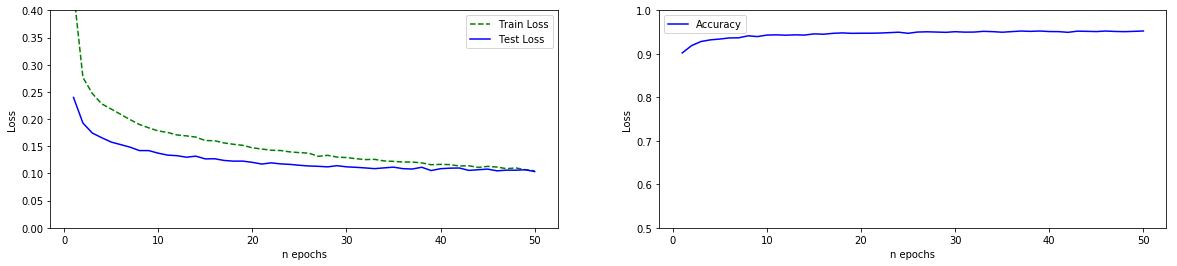

In [7]:
test_loss_min = np.Inf

list_train_loss, list_test_loss, list_accuracy = [], [], []

for e in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0
    ###################
    # train the model #
    ###################
    Model.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_hat = Model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #if (batch_idx+1)%2000==0 or (batch_idx+1)==len(train_loader):
        #    print('Current Epoch: {}/{}, Current progress {}/{}, Train Loss: {:.6f}'.format(e+1, n_epochs,
        #                                                                                   batch_idx+1, len(train_loader),
        #                                                                                  train_loss))
    ######################    
    # Test the model #
    ######################  
    Model.eval()
    for batch_idx, (x, y) in enumerate(test_loader):
        ## update the average validation loss
        with torch.no_grad():
            y_hat = Model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.item() 
            
            pred_y_hat = y_hat>0.5
            equals = pred_y_hat.type(torch.FloatTensor)==y
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            
    test_loss /= len(test_loader)
    accuracy /= len(test_loader)
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}\tTest Accuracy: {:.3f} %'.format(e+1, 
                                                                                                     n_epochs,
                                                                                                     train_loss,
                                                                                                     test_loss,
                                                                                                     accuracy*100))
    
     ## TODO: save the model if validation loss has decreased
    if test_loss < test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(test_loss_min, test_loss))
        torch.save(Model.state_dict(), save_path)
        test_loss_min = test_loss
        
    list_train_loss +=[train_loss]
    list_test_loss += [test_loss]
    list_accuracy += [accuracy]
    
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.arange(1, n_epochs+1), list_train_loss,"--g", label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), list_test_loss, "-b", label='Test Loss')
plt.xlabel("n epochs")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,0.4)
    
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.arange(1, n_epochs+1), list_accuracy, "-b", label='Accuracy')
plt.xlabel("n epochs")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0.5,1)